# Variational Dicke State Preparation

## Imports

In [1]:
# Imports
import math
import cmath
%matplotlib inline
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from numpy import linalg as la
from scipy import linalg as sla
from scipy.special import binom
from IPython.display import clear_output
import time
import pickle
from qiskit.extensions import XGate, UnitaryGate
from qiskit import *
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
import itertools
import pickle
from datetime import datetime
from qiskit.quantum_info.synthesis import two_qubit_cnot_decompose as two_qubit_decomp

# Local import
from DickeCircuit import DickeCirc, DickeCountParam
from DickeStates import Dicke_exp

## Functions

In [2]:
# Partial swap matrix
def pswap(theta):
    
    mat = np.array([[1,0,0,0],[0,np.cos(theta),-np.sin(theta),0],[0,np.sin(theta),np.cos(theta),0],[0,0,0,1]])
    
    return mat

# Return classical list of bits in D(n,k)
def keys_fun(n,k):
    result = []
    for bits in itertools.combinations(range(n), k):
        s = ['0'] * n
        for bit in bits:
            s[bit] = '1'
        result.append(''.join(s))
    return result

# Get counts from Dicke circuit
def DickeCounts(n,k,layer,theta,shots,init):
    qc = DickeCirc(n,k,layer,theta,init)
    qc.measure(range(n),range(n))
    backend      = Aer.get_backend("qasm_simulator")
    simulate     = execute(qc, backend=backend, shots=shots)
    counts = simulate.result().get_counts()
    return counts

# Calculate state overlap (fidelity) between estimated and exact Dicke state as objective function given theta
def objG_state_overlap(theta,constants):
    
    n = constants[0]
    k = constants[1]
    layer = constants[2]
    shots = constants[3]
    init = constants[4]
       
    counts = DickeCounts(n,k,layer,theta,shots,init)
    optimal = binom(n,k)
    dotproduct = 0
    for key,value in counts.items():
        dotproduct += math.sqrt(value/shots)

    return (1 - dotproduct**2/optimal)

# Calculate state overlap given counts
def state_overlap(counts):
       
    optimal = binom(n,k)
    keys = keys_fun(n,k)
    
    dotproduct = 0
    for key,value in counts.items():
        if key in keys:
            dotproduct += math.sqrt(value/shots)

    return dotproduct**2/optimal

# Optimized parameters of circuit (theta)
def Dicke(n,k,layer,shots,init):
    
    objf = objG_state_overlap
    
    n_theta = DickeCountParam(n,k,layer)
    constants = [n,k,layer,shots,init]

    theta = []
    for i in range(n_theta):
        theta.append(np.random.uniform(0,2*np.pi))

    x_list = []
    def callback(x):
        x_list.append(objf(x,constants))
        itr = np.linspace(1,len(x_list),len(x_list))
        plt.plot(itr,x_list)
        clear_output(wait=True)
        plt.show()

    opt = sp.optimize.minimize(objf, x0=theta, args=constants, method = 'Powell', callback=callback)
    theta_min = opt.x
    print(theta_min)

    counts_min = DickeCounts(n,k,layer,theta_min,shots,init)
    print(counts_min)

    std_best = objf(theta_min,constants)
    print(std_best)
    
    return theta_min

## Optimize

In [ ]:
# Inputs
n = 4
k = 2
layer = 2
shots = 2000 
init = 'mixed'

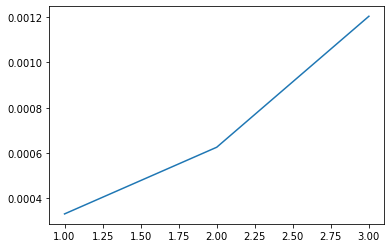

[6.53629361 4.72439317 2.00877174 3.02681398 5.11348915 4.17144624]
{'0101': 360, '0110': 329, '0011': 329, '1001': 310, '1100': 350, '1010': 322}
0.0007723071512778512


In [5]:
# Minimize
theta_min = Dicke(n,k,layer,shots,init)

In [6]:
# Pickle dump
pickle.dump(theta_min,open("D" + str(n) + str(k) + "_theta_min", "wb"))

## Compare Methods

### Variational

0.9981357532666181


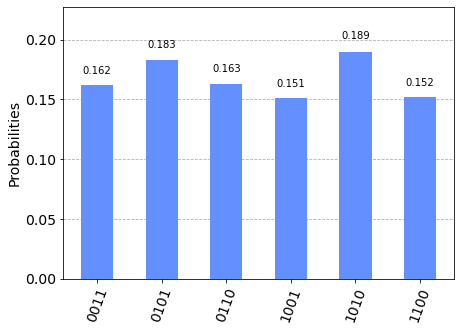

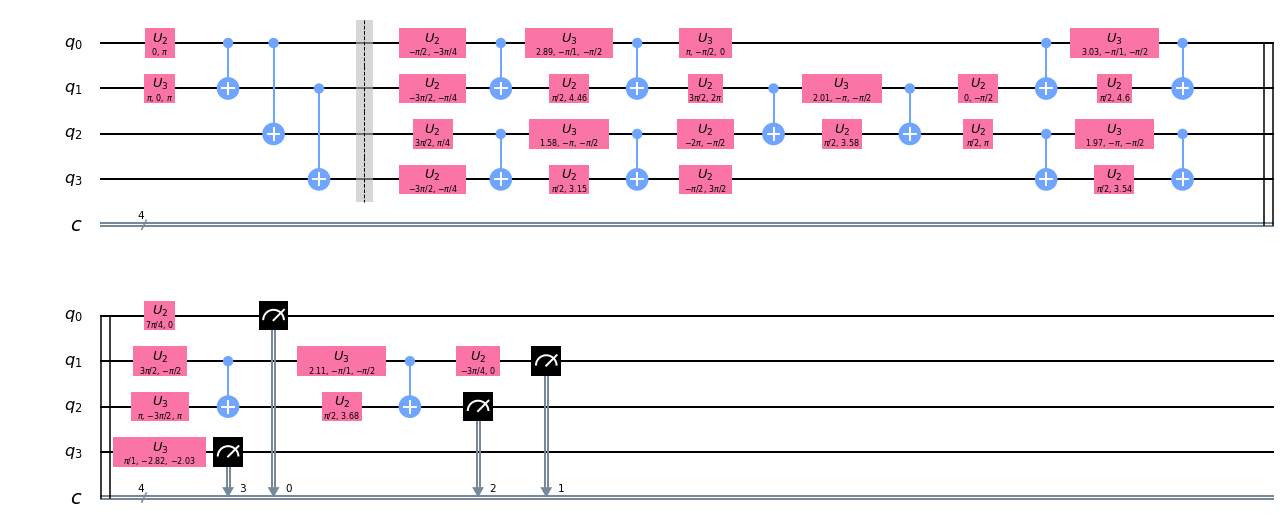

In [7]:
# No noise
shots = 2048

theta_min = pickle.load(open("D" + str(n) + str(k) + "_theta_min","rb"))

qc = DickeCirc(n,k,layer,theta_min,init)

# display (qc.draw(output='mpl'))

# qc = transpile(qc, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=3)

qc.measure(range(n),range(n))
backend = Aer.get_backend("qasm_simulator")
simulate = execute(qc, backend=backend, shots=shots)
results = simulate.result()

counts = results.get_counts()

print(state_overlap(counts))

display(plot_histogram(counts))

qc = transpile(qc, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=3)

qc.draw(output='mpl')

In [ ]:
# Noise

# Shots
shots = 2048

theta_min = pickle.load(open("D" + str(n) + str(k) + "_theta_min","rb"))

qc = DickeCirc(n,k,layer,theta_min,init)

# display (qc.draw(output='mpl'))

qc.measure(range(n),range(n))

qc = transpile(qc, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=3)

provider = IBMQ.load_account()
from qiskit.providers.aer.noise import NoiseModel

# Quantum device to simulate noise of
backend = provider.get_backend('ibmq_16_melbourne')

# Noise Model
noise_model = NoiseModel.from_backend(backend)
coupling_map = backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

# Job from noisey simulation
job = qiskit.execute(qc, Aer.get_backend('qasm_simulator'), noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates, shots=shots)     

counts = job.result().get_counts()

print(state_overlap(counts))

plot_histogram(counts)

### Explicit

0.9996295127502711


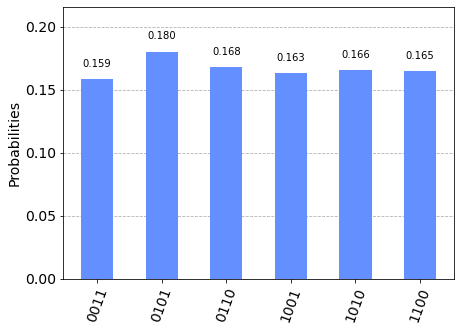

In [8]:
# No noise
shots = 2048

qc = Dicke_exp(n,k)

# display (qc.draw(output='mpl'))

qc.measure(range(n),range(n))
backend = Aer.get_backend("qasm_simulator")
simulate = execute(qc, backend=backend, shots=shots)
results = simulate.result()

counts = results.get_counts()

print(state_overlap(counts))

plot_histogram(counts)

In [ ]:
# Noise

# Shots
shots = 2048

qc = Dicke_exp(n,k)

# display (qc.draw(output='mpl'))

qc.measure(range(n),range(n))

qc = transpile(qc, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=3)

provider = IBMQ.load_account()
from qiskit.providers.aer.noise import NoiseModel

# Quantum device to simulate noise of
backend = provider.get_backend('ibmq_16_melbourne')

# Noise Model
noise_model = NoiseModel.from_backend(backend)
coupling_map = backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

# Job from noisey simulation
job = qiskit.execute(qc, Aer.get_backend('qasm_simulator'), noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates, shots=shots)     

counts = job.result().get_counts()

print(state_overlap(counts))

display(plot_histogram(counts))

qc.draw(output='mpl')


## Plot Difference

In [ ]:
f_old = [0.67,0.58,0.33]
f_new = [0.86,0.80,0.54]
n_list = [4,5,6]

plt.scatter(n_list,f_old,label='Deterministic')
plt.scatter(n_list,f_new,label='Variational')

plt.xlabel('n')
plt.ylabel('Fidelity')

plt.legend()
plt.show()